# Time series plotting around reservoirs

## To-dos
- [ ] sum precip from mm/hr to mm
- [x] spatial aggregation of GRACE subset to single time series
- [x] spatial aggregation of CYGNSS subset to single time series
- [x] spatial aggregation of IMERG subset to single time series
- [ ] convert time series functions & spatial functions to new class

In [1]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'

In [2]:
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(func_dir)
import load_data
import time_series_calcs
import plotting_functions
import area_subsets
import area_calcs

In [3]:
fw_DA = load_data.load_CYGNSS_05()
grace_dict = load_data.load_GRACE()
res_shp = load_data.load_GRanD()
precip_DA = load_data.load_IMERG()

In [4]:
def single_timeseries_IMERG_CYGNSS_GRACE(dam_name,subset_method='polygon',**plot_params):
    """
    Description
    -----------
    Hard-coded time series slicing for IMERG and CYGNSS to start two months after the intersecting_timeframes() start date
    
    Inputs
    ------
    dam_name: name of a dam in the GRanD reservoir dataset
    subset_method : str
        default : 'polygon'
        accepted : 'polygon' , 'point'
        allows for updated polygon or older point-based subsetting
    **plot_params : dict
        dictionary of plot formatting options and labels
            Keys used: None, all passed to `three_part_timeseries`

    Outputs
    -------
    precip , fw , cmwe : Pandas Series
        Series used for plotting
        Respectively, precipitation, fractional water, TWS
    """
    global precip_DA , fw_DA , grace_dict, res_shp
    
    if 'polygon' in subset_method.lower():
        precip_multi , precip_full = area_subsets.precip_shape_subset(dam_name,
                             res_shp,
                             precip_DA,
                             buffer_val=0.25,
                             crs_code=4326)

        fw_multi , fw_full = area_subsets.cygnss_shape_subset(dam_name,
                             res_shp,
                             fw_DA,
                             buffer_val=0.25,
                             crs_code=4326)
        cmwe_multi , mascon_ts , cmwe_full = area_subsets.grace_shape_subset(dam_name,
                                res_shp,
                                grace_dict,
                                buffer_val=0)        
    elif 'point' in subset_method.lower():
        coords_i = area_subsets.reservoir_name_to_point(res_oi,res_shp)
        
        precip_full = area_subsets.precip_point_subset(coords_i,precip_DA)
        fw_full = area_subsets.cygnss_point_subset(coords_i,fw_DA)
        cmwe_full , mascon_ts = area_subsets.grace_point_subset(coords_i,grace_dict)

    precip , fw , cmwe = time_series_calcs.intersecting_timeframes(precip_full,fw_full,cmwe_full,buffer=0)
    precip = precip[2:]
    fw = fw[2:]
    
    plot_params['data_labels'] = ['IMERG','CYGNSS','GRACE']
    plot_params['x_label'] = 'Time'
    plot_params['y_labels'] = ['Precip (mm/hr)', 'Fraction of surface water coverage', 'TWS water equivalence (cm)']
    plot_params['line_fmt'] = ['c-','b-','k-']
    plot_params['figsize'] = (12,6)

    plotting_functions.three_part_timeseries([precip , fw , cmwe],**plot_params)
    
    return precip , fw , cmwe

In [5]:
res_coords_dict = {
    'merowe' : (18.68 , 32.06),
    'indirasagar' : (22.18,76.6),
    'estreito' : (-6.50001 ,-47.0)
}

polygon subsetting


/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:205: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)
/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:205: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)


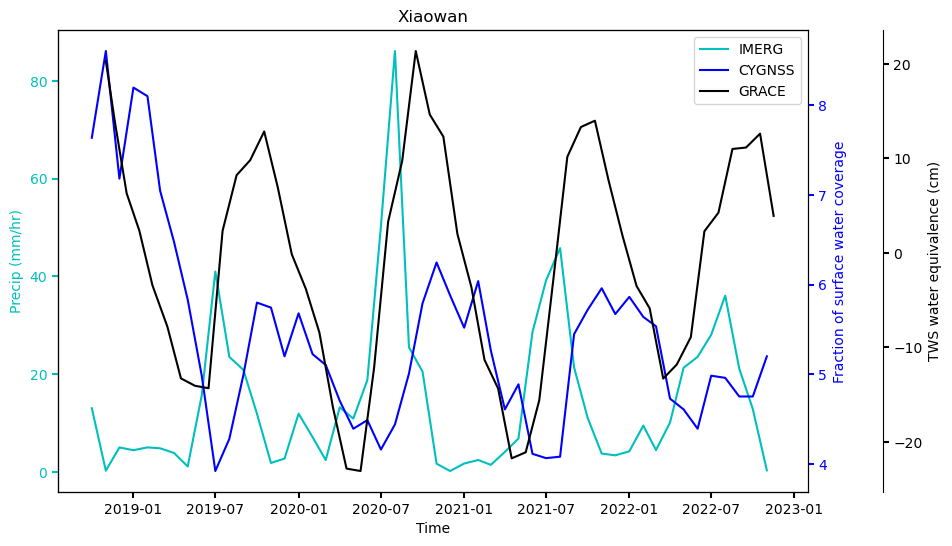

In [6]:
res_oi = 'Xiaowan'
plot_params = {
    'title' : res_oi
}
precip_series , fw_series , cmwe_series = single_timeseries_IMERG_CYGNSS_GRACE(
    res_oi,
    **plot_params,
    subset_method='polygon')

In [7]:
def series_to_TSM_object(input_series,*TSM_args,**TSM_kwargs):
    series_obj = input_series.astype(float)
    series_obj.index = list(map(time_series_calcs.toYearFraction,series_obj.index))
    TSM_obj = time_series_calcs.TimeSeriesMetrics(series_obj,*TSM_args,**TSM_kwargs)
    return TSM_obj

In [8]:
precip_ts = series_to_TSM_object(precip_series,'IMERG')
fw_ts = series_to_TSM_object(fw_series,'CYGNSS')
cmwe_ts = series_to_TSM_object(cmwe_series,'GRACE')

In [9]:
# precip_ts.coef_determination(fw_ts)
# precip_ts.coef_determination(cmwe_ts)
fw_ts.coef_determination(precip_ts)
# fw_ts.coef_determination(cmwe_ts)
cmwe_ts.coef_determination(precip_ts)
cmwe_ts.coef_determination(fw_ts);

---coef of determination----
Between CYGNSS and IMERG
-311.36407868544813
---coef of determination----
Between GRACE and IMERG
-1.0679947480030076
---coef of determination----
Between GRACE and CYGNSS
0.03590561931225067


## Spatial aggregation work of polygon subset to single time series

In [10]:
test_cmwe

NameError: name 'test_cmwe' is not defined

In [ ]:
# GRACE = success.
test_cmwe , test_mascon = area_subsets.grace_shape_subset('Xiaowan',
                                res_shp,
                                grace_dict,
                                buffer_val=0)
test_cmwe_agg = test_cmwe.mul(test_mascon['area_km2'],axis='index').sum(axis=0)/(test_mascon['area_km2'].sum())
    # weighted average
test_polygon_agg = test_mascon.geometry.unary_union

In [ ]:
# CYGNSS = success.
test_fw = area_subsets.xr_shape_subset('Xiaowan',
                             res_shp,
                             fw_DA,
                             buffer_val=0.25,
                             crs_code=4326)
test_fw_agg = test_fw.mean(dim=['lat','lon'])

In [ ]:
# IMERG

test_precip = area_subsets.xr_shape_subset('Indirasagar',
                             res_shp,
                             precip_DA,
                             buffer_val=0.25,
                             crs_code=4326)

test_precip_agg = test_precip.sum(dim=['lat','lon'])

In [ ]:
test_precip_agg.values

In [ ]:
test_precip_dates = time_series_calcs.IMERG_timestep_to_pdTimestamp(test_precip_agg['time'])
pd.Series(data=test_precip_agg,index=test_precip_dates)

In [ ]:
test_fw.isel(time=1).plot()

## Scratchwork

In [ ]:
coords_i = area_subsets.reservoir_name_to_point('Indirasagar',res_shp)

precip_xr = precip_DA.sel(lat=coords_i[0],lon=coords_i[1],method='nearest')
dates_precip = np.array(list(map(lambda x: pd.Timestamp('1980-01-06') + pd.DateOffset(seconds=x),precip_xr['time'].values)))
    # Time = seconds since 1980 Jan 06 (UTC), per original HDF5 IMERG file units
precip_ts = pd.Series(data=precip_xr,index=dates_precip)

In [ ]:
def IMERG_timestamp_to_pdTimestamp(input_xrcoord):
    dates_precip = np.array(list(map(lambda x: pd.Timestamp('1980-01-06') + pd.DateOffset(seconds=x),input_xrcoord.values)))
    return dates_precip

In [ ]:
print(precip_xr['time'])

In [ ]:
area_subsets.reservoir_name_to_point('Xiaowan',res_shp) , area_subsets.reservoir_name_to_point('Nuozhadu',res_shp)

In [ ]:
res_shp[res_shp['DAM_NAME'] =='Nuozhadu'].squeeze().head(15)

In [ ]:
res_shp[res_shp['ADMIN_UNIT'] == 'Yunnan']

In [ ]:
res_shp.loc[:,['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM']].sort_values('CAP_MCM',ascending=False)

In [ ]:
res_shp.loc[res_shp['MAIN_BASIN'] == 'Mekong',['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM']].sort_values('CAP_MCM',ascending=False)